# Downscaling Temperature at 2m for **NYC Tristate** area

**Variables:**
* Variable to be downscaled: Temperature at 2 meters (T2)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 115,291.16 km²

# Instructions

Once all the necessary libraries have been installed into your virtual enviornment we can begin to run the downscaling model. In the "Define paths ..." section, please update the paths to the data files.

# Import libraries

In [1]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

2025-02-21 09:43:31.602942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 09:43:31.647846: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-21 09:43:31.648744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-21 09:43:33.351610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!python --version
#Should be Python 3.8.18

Python 3.8.18


# Define paths and retrieve files from server

These files include both T2 and PSFC variables. If we want to run the model without a predictor variable, make sure ```predictors_train=None, predictors_val=None, predictors_test=None``` when training the model. 

In [3]:
uwrf_train = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/uWRF/uWRF_train_tristate_01-02.nc') #**change**
uwrf_val = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/uWRF/uWRF_val_tristate_03.nc') #**change**
uwrf_test = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/uWRF/uWRF_test_tristate_03.nc') #**change**

nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/NAM/nam_train_tristate_01-02.nc') #**change**
nam_val = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/NAM/nam_val_tristate_03.nc') #**change**
nam_test = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/NAM/nam_test_tristate_03.nc') #**change**

# Calculating spatial coverage

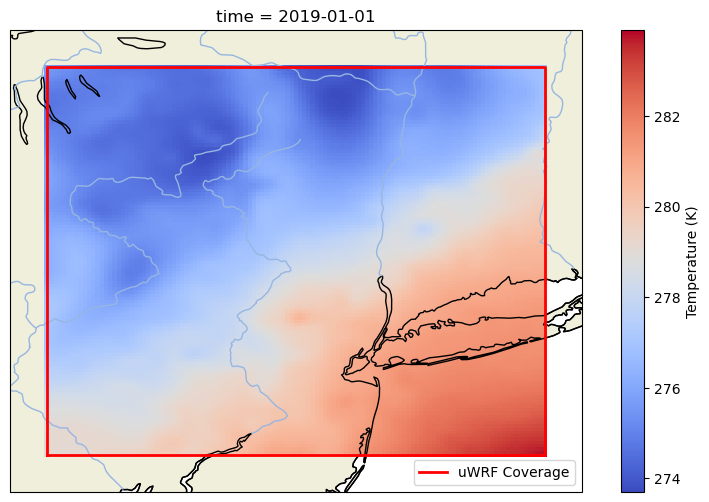

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Calculating min and max lat and lon
uwrf_min_lat = min(uwrf_train['latitude'].values)
uwrf_max_lat = max(uwrf_train['latitude'].values)
uwrf_min_lon = min(uwrf_train['longitude'].values)
uwrf_max_lon = max(uwrf_train['longitude'].values)

nam_min_lat = min(nam_train['latitude'].values)
nam_max_lat = max(nam_train['latitude'].values)
nam_min_lon = min(nam_train['longitude'].values)
nam_max_lon = max(nam_train['longitude'].values)



# Extract T2 for the first timestep
t2_first = uwrf_train['T2'].isel(time=0)

# Get spatial coverage
uwrf_min_lat = t2_first['latitude'].values.min()
uwrf_max_lat = t2_first['latitude'].values.max()
uwrf_min_lon = t2_first['longitude'].values.min()
uwrf_max_lon = t2_first['longitude'].values.max()

# Plotting with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title("uWRF Dataset Coverage and T2 Field (First Time Step)", fontsize=14)

# Add coastlines and features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS)

# Plot T2 data
t2_first.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'Temperature (K)'})

# Add bounding box
ax.plot(
    [uwrf_min_lon, uwrf_min_lon, uwrf_max_lon, uwrf_max_lon, uwrf_min_lon],
    [uwrf_min_lat, uwrf_max_lat, uwrf_max_lat, uwrf_min_lat, uwrf_min_lat],
    color='red', transform=ccrs.PlateCarree(), linewidth=2, label='uWRF Coverage'
)

# Set extent for the map
ax.set_extent([uwrf_min_lon - 0.3, uwrf_max_lon + 0.3, uwrf_min_lat - 0.3, uwrf_max_lat + 0.3])

# Add legend
ax.legend(loc='lower right')

plt.show()


In [5]:
import numpy as np

def calculate_area(min_lat, max_lat, min_lon, max_lon):
    R = 6371

    min_lat_rad = np.radians(min_lat)
    max_lat_rad = np.radians(max_lat)
    min_lon_rad = np.radians(min_lon)
    max_lon_rad = np.radians(max_lon)

    # Calculate differences
    delta_lat = max_lat_rad - min_lat_rad
    delta_lon = max_lon_rad - min_lon_rad

    # Area of a spherical rectangle segment
    area = (R**2) * delta_lon * (np.sin(max_lat_rad) - np.sin(min_lat_rad))
    return abs(area)

# uWRF area
uwrf_area = calculate_area(uwrf_min_lat, uwrf_max_lat, uwrf_min_lon, uwrf_max_lon)
print(f"uWRF Area: {uwrf_area:.2f} km²")

# NAM area
nam_area = calculate_area(nam_min_lat, nam_max_lat, nam_min_lon, nam_max_lon)
print(f"NAM Area: {nam_area:.2f} km²")

# Intersection area
intersection_area = calculate_area(
    max(uwrf_min_lat, nam_min_lat),
    min(uwrf_max_lat, nam_max_lat),
    max(uwrf_min_lon, nam_min_lon),
    min(uwrf_max_lon, nam_max_lon),
)
if intersection_area > 0:
    print(f"Intersection Area: {intersection_area:.2f} km²")
else:
    print("No overlap between the datasets.")


uWRF Area: 121205.96 km²
NAM Area: 115291.16 km²
Intersection Area: 115291.16 km²


# Define variables

In [6]:
#High resolution (uWRF) data
T2_hr_train = uwrf_train.T2
T2_hr_val = uwrf_val.T2
T2_hr_test = uwrf_test.T2

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC
#--------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2
T2_lr_val = nam_val.T2
T2_lr_test = nam_test.T2

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Scale the data

In [7]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)

# Compare original resolutions

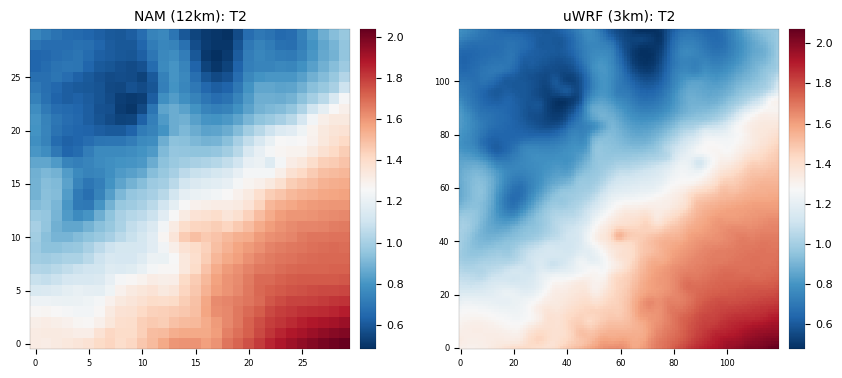

In [8]:
#T2: Temperature at 2 meters
ecv.plot((x_train[0].values, y_train[0]), subplot_titles=('NAM (12km): T2', 'uWRF (3km): T2'))

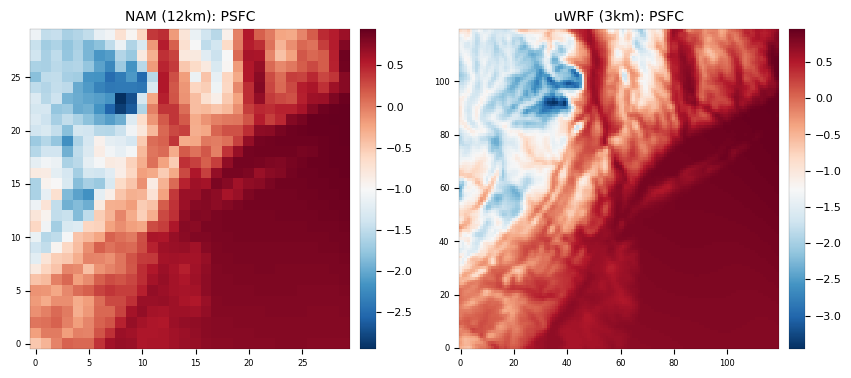

In [9]:
#PSFC: Surface Pressure
ecv.plot((x_z_train[0].values, y_z_train[0]), subplot_titles=('NAM (12km): PSFC', 'uWRF (3km): PSFC'))

# Add channel dimension

In [10]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

# Verify shape

In [11]:
print("T2 hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("T2 lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

T2 hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

PSFC hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

T2 lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)

PSFC lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)


# Example coarsening method occuring during training:

For this model, we do not use the LR data (NAM) during training. Instead, we use a coarsened version (via interpolation) of the HR (uWRF) T2 and PSFC data. The DL4DS model carries out this interpolation on the fly by using the helper function dds.create_pair_hr_lr() (not to be called by the user). This process is done **automatically** inside the training loop (by calling one of the two (Supervised vs GAN) Trainer classes in DL4DS), which we examplify here with the spc upsampling. 

HR array: (120, 120, 1), LR array (30, 30, 2)


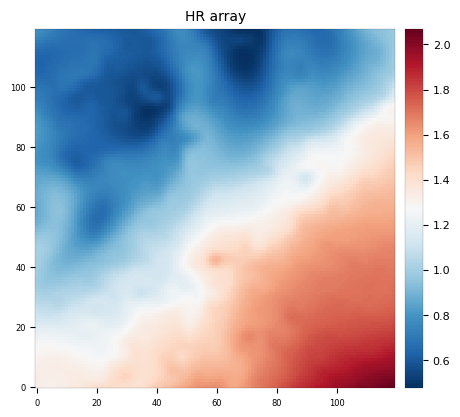

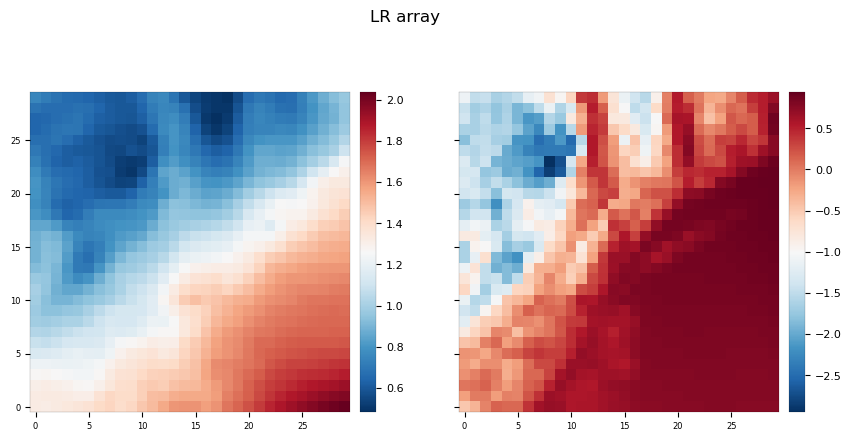

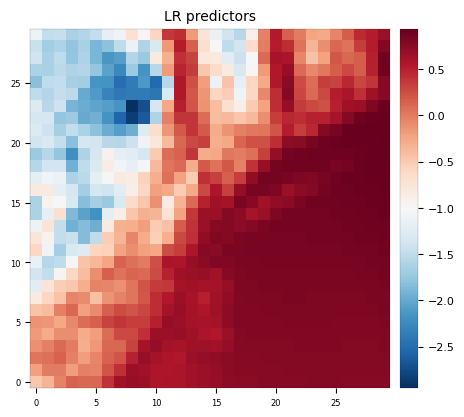

In [12]:
df = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

# Training Model

Tuning hyperparameters:

* filters
* blocks
* filter size: Cannot change
* stride: Cannot change
* padding: Cannot change
* learning rate
* batch size
* upsampling
* epochs
* learning rate

Possible backbones:

* resnet
* densenet
* convnet
* convnext

In [17]:
import os
import shutil
import csv

#------------------------------------------------------------------------------------
results = []
best_loss = float('inf')
best_model_path = "/home/gvaillant1/downscaling/pretrained-models/T2-Tristate-Best-Model" #**change**
other_models_path = "/home/gvaillant1/downscaling/pretrained-models/T2-Tristate-Other-Models" #**change**
test_loss_file = os.path.join(other_models_path, "test_loss.txt")
runtime_file = os.path.join(other_models_path, "running_time.txt")
csv_file = "/home/gvaillant1/downscaling/results/model_results.csv" #**change**

#------------------------------------------------------------------------------------
#TESTING DIFFERENT HYPER PARAMETERS:
#change the hyperparams to test different models
backbones = ['resnet', 'densenet']
num_filters = [4] #16 31 
num_blocks = [6] # 8 12
epochs = [3]
#epochs = [25, 50, 100]
lrate = (1e-3, 1e-4)
#------------------------------------------------------------------------------------

#Check the existing results csv file to see if the parameter combination has already been tested
existing_results = []
if os.path.exists(csv_file):
    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        next(reader, None)  # Skip header
        for row in reader:
            existing_results.append(tuple(row))

# Retrieve the lowest loss from CSV before training
if existing_results:
    best_loss = min(float(row[2]) for row in existing_results if row[2] != "NULL")

for backbone in backbones:
    for filters in num_filters:
        for blocks in num_blocks:
            for epoch in epochs:
                ARCH_PARAMS = dict(n_filters=filters,
                                   n_blocks=blocks,
                                   normalization=None,
                                   dropout_rate=0.5,
                                   dropout_variant='spatial',
                                   attention=False,
                                   activation='relu',
                                   localcon_layer=False)
    
                print(f"Running model with backbone={backbone}, filters={filters}, blocks={blocks}, epochs={epoch}")
    
                trainer = dds.SupervisedTrainer(
                    backbone=backbone,
                    upsampling='spc',
                    data_train=y_train,
                    data_val=y_val,
                    data_test=y_test,
                    data_train_lr=None,
                    data_val_lr=None,
                    data_test_lr=None,
                    scale=4,
                    time_window=None,
                    static_vars=None,
                    predictors_train=None, #Add predictor information here (not required)
                    predictors_val=None, #Add predictor information here (not required)
                    predictors_test=None, #Add predictor informatio here (not required)
                    interpolation='inter_area',
                    patch_size=None,
                    batch_size=60,
                    loss='mae',
                    epochs=epoch,
                    steps_per_epoch=None,
                    validation_steps=None,
                    test_steps=None,
                    learning_rate=lrate,
                    lr_decay_after=1e4,
                    early_stopping=False,
                    patience=6,
                    min_delta=0,
                    save=True,
                    save_bestmodel=True,
                    save_path=other_models_path,
                    show_plot=True,
                    verbose=True,
                    device='CPU',
                    **ARCH_PARAMS)
    
                # Create unique model identifier (ensure all fields match CSV format)
                #Needed to specify the datatypes so the code will be able to correctly check if we have done the model before
                model_id = (str(y_train.name), "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                            backbone, str(filters), str(blocks), str(lrate), trainer.interpolation, trainer.upsampling, 
                            str(trainer.epochs), trainer.loss, str(trainer.early_stopping))
    
                model_id = (
                    str(y_train.name),
                    "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                    backbone,
                    str(filters),
                    str(blocks),
                    str(lrate),
                    trainer.interpolation,
                    trainer.upsampling,
                    str(trainer.epochs),
                    trainer.loss,
                    str(trainer.early_stopping)
                )
    
                print(f"Checking if model has already been tested: {model_id}")
    
                #Check if model already exists in CSV
                model_exists = False
                for row in existing_results:
                    existing_model_id = (row[0], row[1], row[3], row[4], row[5], row[11], 
                                         row[9], row[8], row[6], row[12], row[13])
                    #print(f"Comparing with existing model: {existing_model_id}")
                    
                    if existing_model_id == model_id:
                        print("Match found! Skipping training for:", model_id)
                        model_exists = True
                        break
                
                if model_exists:
                    continue
    
                trainer.run()
    
                if os.path.exists(test_loss_file):
                    with open(test_loss_file, "r") as f:
                        val_loss = float(f.read().strip())
                else:
                    val_loss = float('inf')
    
                if os.path.exists(runtime_file):
                    with open(runtime_file, "r") as f:
                        training_runtime = f.read().strip()
                else:
                    training_runtime = "NULL"

                model_save_path = other_models_path  # Default save path

                #Check if the loss we just calculated is the lowest
                #If so, it is the best model and it should be put in the best model directory
                if val_loss < best_loss:
                    best_loss = val_loss

                    # Remove previous best model completely before replacing it
                    if os.path.exists(best_model_path):
                        shutil.rmtree(best_model_path)  # Delete the entire directory
    
                    # Move new best model to the best model directory
                    shutil.move(other_models_path, best_model_path)
                    model_save_path = best_model_path #replace the model_save_path with the best model path if it has a lower loss
                    print('Moved to best model directory')
    
                results.append((str(y_train.name), "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                                val_loss, backbone, filters, blocks, trainer.epochs, 
                                trainer.model.count_params(), trainer.upsampling, trainer.interpolation, 
                                trainer.batch_size, lrate, trainer.loss, trainer.early_stopping, 
                                training_runtime, model_save_path))
    
                #Write the information about the model and results in the results CSV file
                file_exists = os.path.isfile(csv_file)
                with open(csv_file, mode='a', newline='') as f:
                    writer = csv.writer(f)
                    if not file_exists:
                        writer.writerow(["Downscaled Variable", "Predictor", "Test Loss",
                                         "Backbone", "Filters", "Blocks",
                                        "Epochs", "Parameters", "Upsampling Method",
                                         "Interpolation Method", "Batch Size", "Learning Rate",
                                        "Loss Function", "Early Stopping", "Training Runtime", "Model Path"])
                    writer.writerow([str(y_train.name), "NULL" if trainer.predictors_train is None else str(trainer.predictors_train.name),
                                     val_loss, backbone, filters, blocks,
                                     trainer.epochs, trainer.model.count_params(), trainer.upsampling,
                                     trainer.interpolation, trainer.batch_size, lrate, 
                                     trainer.loss, trainer.early_stopping, training_runtime, model_save_path])

print("Training complete")


Running model with backbone=resnet, filters=4, blocks=6, epochs=3
List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
Checking if model has already been tested: ('T2', 'NULL', 'resnet', '4', '6', '(0.001, 0.0001)', 'inter_area', 'spc', '3', 'mae', 'False')
Match found! Skipping training for: ('T2', 'NULL', 'resnet', '4', '6', '(0.001, 0.0001)', 'inter_area', 'spc', '3', 'mae', 'False')
Running model with backbone=densenet, filters=4, blocks=6, epochs=3
List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
Checking if model has already been tested: ('T2', 'NULL', 'densenet', '4', '6', '(0.001, 0.0001)', 'inter_area', 'spc', '3', 'mae', 'False')
Match found! Skipping training for: ('T2', 'NULL', 'densenet', '4', '6', '(0.001, 0.0001)', 'inter_area', 'spc', '3', 'mae', 'False')
Training complete


# Inference on uWRF test set

In [14]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=64,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-02-21 09:43:47
--------------------------------------------------------------------------------


AttributeError: 'SupervisedTrainer' object has no attribute 'name'

# Inference on NAM

In [ ]:
pred1 = dds.Predictor(
    trainer, 
    x_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

# Inference on unseen NAM (may data)
May uwrf data was not seen during training at all. So we will feed the model May NAM data and see how it performs.

In [ ]:
may_data = xr.open_dataset('/D4/data/gvaillant/NAM/2019/may/aligned/aligned_nam_may_data.nc')

T2_may = may_data.T2

may_train = T2_scaler_train.transform(T2_may)

In [ ]:
may_train = may_train.expand_dims(dim='channel', axis=-1)

In [ ]:
may_train.shape

In [ ]:
pred_new = dds.Predictor(
    trainer, 
    may_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_may_pred, coarsened_array_may = pred_new.run()

In [ ]:
unscaled_may_train = T2_scaler_train.inverse_transform(may_train)

ecv.plot((unscaled_may_train[100].values, unscaled_may_pred[100]),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results'))

# Comparing predictions on uWRF test set

In [ ]:
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_x_test[1].values, unscaled_y_pred[1], unscaled_y_test[1].values),
         share_colorbar=True, share_dynamic_range=True, show_coastline=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

mae = dds.losses.mae(unscaled_y_test[0].values, unscaled_y_pred[0])
print(f"MAE for test set: {mae}")

# Comparing predictions on NAM data 

In [ ]:
unscaled_x_train = T2_scaler_train.inverse_transform(x_train)
unscaled_y_train = T2_scaler_train.inverse_transform(y_train)
ecv.plot((unscaled_x_train[0].values, unscaled_x_pred[0], unscaled_y_train[0].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled Temperature Results', 'uWRF'))

In [ ]:
#Only problem here is that the coastlines are not where they should be plotted!
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Latitude and longitude for NAM
nam_lat = np.array([39.83631 , 39.943615, 40.05092 , 40.158245, 40.265556, 40.372875,
       40.480194, 40.587536, 40.69487 , 40.802197, 40.90954 , 41.016872,
       41.12421 , 41.23156 , 41.338894, 41.44624 , 41.553577, 41.660915,
       41.768246, 41.875576, 41.982914, 42.09025 , 42.19757 , 42.304882,
       42.41221 , 42.51952 , 42.626823, 42.73413 , 42.84143 , 42.948727])
nam_lon = np.array([-76.70499 , -76.56531 , -76.42578 , -76.28638 , -76.147095, -76.007965,
       -75.86896 , -75.7301  , -75.59137 , -75.45282 , -75.31436 , -75.176056,
       -75.03787 , -74.89984 , -74.76196 , -74.62421 , -74.48663 , -74.34918 ,
       -74.21185 , -74.07468 , -73.93765 , -73.80078 , -73.66403 , -73.527466,
       -73.39099 , -73.2547  , -73.11856 , -72.982544, -72.84671 , -72.711])

#extra lat: 40.93637, 40.963203, 40.99004
#extra lon: -73.66403, -73.62988, -73.5957
# Latitude and longitude for uWRF and downscaled data
uwrf_lat = np.array([
       39.83631 , 39.86314 , 39.88997 , 39.916782, 39.943615, 39.97044 ,
       39.997265, 40.0241  , 40.05092 , 40.07775 , 40.104576, 40.13141 ,
       40.158245, 40.18507 , 40.21189 , 40.23872 , 40.265556, 40.292385,
       40.319218, 40.34605 , 40.372875, 40.39971 , 40.426544, 40.453365,
       40.480194, 40.507034, 40.53387 , 40.5607  , 40.587536, 40.614372,
       40.64121 , 40.668037, 40.69487 , 40.7217  , 40.748535, 40.775364,
       40.802197, 40.829033, 40.85587 , 40.882706, 40.90954 , 40.93637 ,
       40.963203, 40.99004 , 41.016872, 41.043705, 41.07055 , 41.097378,
       41.12421 , 41.151054, 41.17788 , 41.20472 , 41.23156 , 41.25839 ,
       41.285217, 41.31206 , 41.338894, 41.365723, 41.39257 , 41.419403,
       41.44624 , 41.47307 , 41.499912, 41.52674 , 41.553577, 41.580418,
       41.607243, 41.63408 , 41.660915, 41.687748, 41.714584, 41.741417,
       41.768246, 41.79508 , 41.82192 , 41.848743, 41.875576, 41.90242 ,
       41.929253, 41.956085, 41.982914, 42.009743, 42.036575, 42.063416,
       42.09025 , 42.11707 , 42.1439  , 42.170734, 42.19757 , 42.2244  ,
       42.251232, 42.278053, 42.304882, 42.331726, 42.358555, 42.38538 ,
       42.41221 , 42.439037, 42.465866, 42.49269 , 42.51952 , 42.54635 ,
       42.573177, 42.60001 , 42.626823, 42.653652, 42.680485, 42.70731 ,
       42.73413 , 42.760956, 42.78778 , 42.81461 , 42.84143 , 42.868256,
       42.895073, 42.921898, 42.948727, 42.975536, 43.002365, 43.029186
])
uwrf_lon = np.array([
       -76.70499 , -76.670044, -76.63513 , -76.60022 , -76.56531 , -76.530396,
       -76.495514, -76.46063 , -76.42578 , -76.3909  , -76.35605 , -76.3212  ,
       -76.28638 , -76.251526, -76.216736, -76.181885, -76.147095, -76.112305,
       -76.077515, -76.042725, -76.007965, -75.973206, -75.938446, -75.90369 ,
       -75.86896 , -75.83423 , -75.79953 , -75.76483 , -75.7301  , -75.695435,
       -75.660736, -75.62604 , -75.59137 , -75.55673 , -75.522095, -75.48743 ,
       -75.45282 , -75.41818 , -75.383545, -75.34894 , -75.31436 , -75.279785,
       -75.24518 , -75.21063 , -75.176056, -75.14148 , -75.10693 , -75.07242 ,
       -75.03787 , -75.00336 , -74.96884 , -74.93436 , -74.89984 , -74.86536 ,
       -74.8309  , -74.79642 , -74.76196 , -74.72754 , -74.693085, -74.65863 ,
       -74.62421 , -74.58981 , -74.55542 , -74.520996, -74.48663 , -74.45224 ,
       -74.41788 , -74.383514, -74.34918 , -74.31482 , -74.28049 , -74.246155,
       -74.21185 , -74.17755 , -74.14325 , -74.10895 , -74.07468 , -74.040405,
       -74.006165, -73.97189 , -73.93765 , -73.90341 , -73.8692  , -73.83496 ,
       -73.80078 , -73.76657 , -73.73239 , -73.69821 , -73.66403 , -73.62988 ,
       -73.5957  , -73.561584, -73.527466, -73.49332 , -73.4592  , -73.42511 ,
       -73.39099 , -73.35693 , -73.322845, -73.28876 , -73.2547  , -73.22064 ,
       -73.186615, -73.15259 , -73.11856 , -73.08453 , -73.05054 , -73.01654 ,
       -72.982544, -72.94858 , -72.91461 , -72.88068 , -72.84671 , -72.812775,
       -72.77884 , -72.744934, -72.711   , -72.677124, -72.64322 , -72.609344
])


nam_lon_grid, nam_lat_grid = np.meshgrid(nam_lon, nam_lat)
uwrf_lon_grid, uwrf_lat_grid = np.meshgrid(uwrf_lon, uwrf_lat)

# Dynamically set rows to match the number of time steps
time_steps = [100, 8, 29]
num_time_steps = len(time_steps)
fig, axes = plt.subplots(num_time_steps, 3, subplot_kw={'projection': ccrs.LambertConformal()}, figsize=(15, 5 * num_time_steps))
titles = ['NAM', 'Downscaled Temperature Results', 'uWRF']


for t_idx, i in enumerate(time_steps):
    
    nam_data = unscaled_x_train[i].values  # NAM data
    #nam_data = coarsened_array1[i] #fix this later to see the coarsened data
    downscaled_data = unscaled_x_pred[i]  # Downscaled data
    uwrf_data = unscaled_y_train[i].values  # uWRF data

    # Loop through datasets for the current time step
    for j, (data, title) in enumerate(zip([nam_data, downscaled_data, uwrf_data], titles)):
        ax = axes[t_idx, j] if num_time_steps > 1 else axes[j]  # Handle single-row case
        
        if title == 'NAM':
            # Plot NAM data using imshow
            im = ax.imshow(data[::-1, :], extent=[nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()],
               transform=ccrs.LambertConformal(), cmap='coolwarm', origin='upper')


        else:
            # Plot uWRF data using pcolormesh
            im = ax.pcolormesh(uwrf_lon_grid, uwrf_lat_grid, data, transform=ccrs.LambertConformal(), cmap='coolwarm')


        # Set axis ticks
        if title == 'NAM':
            xticks = [nam_lon[0]] + list(nam_lon[5::5]) + [nam_lon[-1]]
            yticks = [nam_lat[0]] + list(nam_lat[5::5]) + [nam_lat[-1]]
        else:
            xticks = [uwrf_lon[0]] + list(uwrf_lon[20::20]) + [uwrf_lon[-4]]
            yticks = [uwrf_lat[0]] + list(uwrf_lat[20::20]) + [uwrf_lat[-4]]
        
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        
        ax.set_xticklabels([f"{lon:.2f}" for lon in xticks])
        ax.set_yticklabels([f"{lat:.2f}" for lat in yticks])  

        ax.set_title(f"{title} (Time = {i})")
        ax.coastlines(resolution='10m', color='black', linewidth=1.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_extent([nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()], crs=ccrs.LambertConformal())

        
# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Colorbar position
fig.colorbar(im, cax=cbar_ax, label='Temperature')



plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create figure with the Lambert projection
fig, axes = plt.subplots(num_time_steps, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 5 * num_time_steps))
titles = ['NAM', 'Downscaled Temperature Results', 'uWRF']

for t_idx, i in enumerate(time_steps):
    
    nam_data = unscaled_x_train[i].values  # NAM data
    downscaled_data = unscaled_x_pred[i]  # Downscaled data
    uwrf_data = unscaled_y_train[i].values  # uWRF data

    # Loop through datasets for the current time step
    for j, (data, title) in enumerate(zip([nam_data, downscaled_data, uwrf_data], titles)):
        ax = axes[t_idx, j] if num_time_steps > 1 else axes[j]  # Handle single-row case
        
        if title == 'NAM':
            im = ax.imshow(data[::-1, :], extent=[nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()],
               transform=ccrs.PlateCarree(), cmap='coolwarm', origin='upper')  # Ensure PlateCarree transform

        else:
            im = ax.pcolormesh(uwrf_lon_grid, uwrf_lat_grid, data, transform=ccrs.PlateCarree(), cmap='coolwarm')

        # Ensure coastlines and borders are correctly transformed
        ax.coastlines(resolution='10m', color='black', linewidth=1.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        
        # Set extent in PlateCarree (Geographic Coordinates)
        ax.set_extent([nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()], crs=ccrs.PlateCarree())

        ax.set_title(f"{title} (Time = {i})")


cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax)

plt.show()


# Loss calculations

In [ ]:
mae = dds.losses.mae(unscaled_y_test.values[1], unscaled_y_pred[1])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")

